In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

### Load the dataset
We load the datset and take a look to get an idea of what we are dealing with.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/machine learning/food delivery/train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [5]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


### Check for missing data

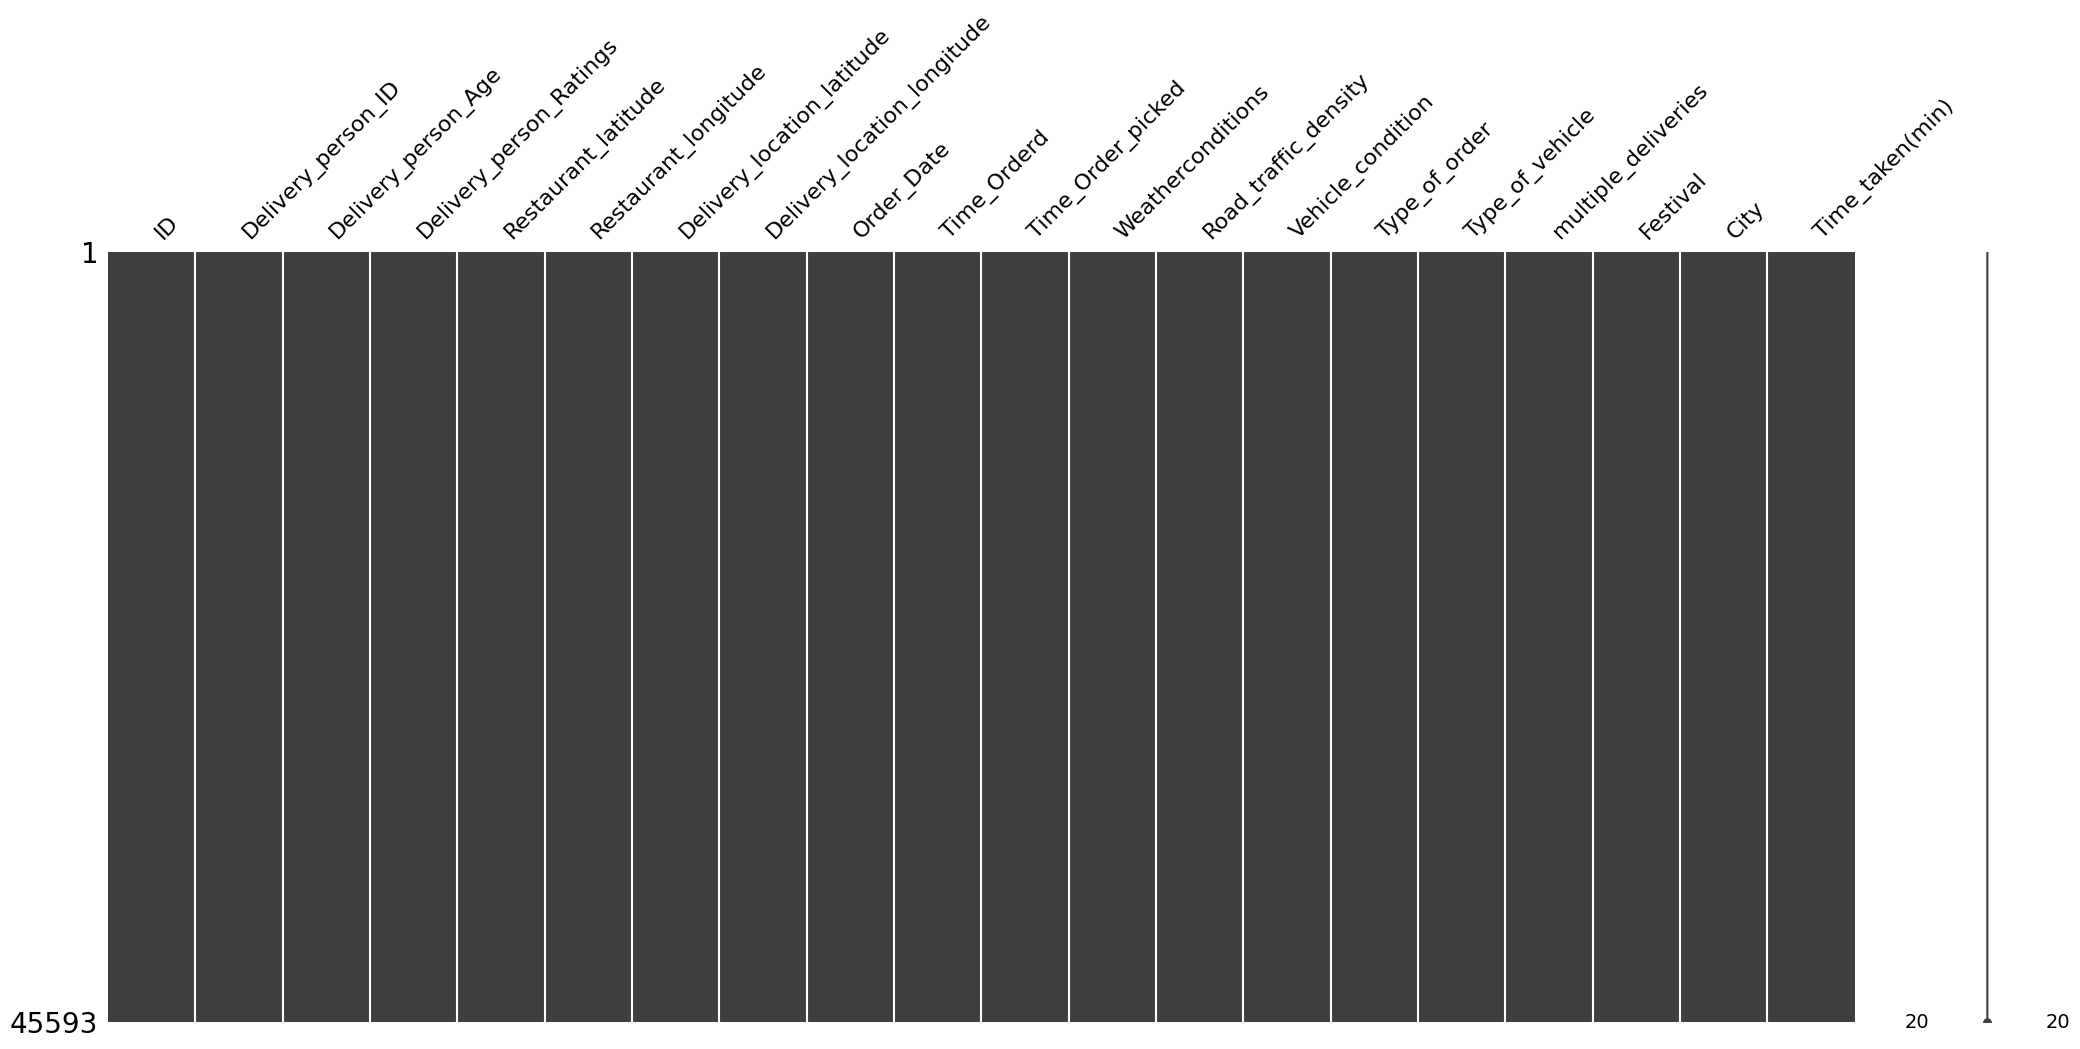

In [6]:
# Plotting missing values as a heatmap
msno.matrix(df)
plt.show()

We use describe() method from pandas to generate descriptive statistics of a DataFrame. It provides a summary of the central tendency, dispersion, and shape of the dataset's distribution.

In [7]:
df.describe()

,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition
count,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000
mean,17.017729,70.231332,17.465186,70.845702,1.023359
std,8.185109,22.883647,7.335122,21.118812,0.839065
min,-30.905562,-88.366217,0.010000,0.010000,0.000000
25%,12.933284,73.170000,12.988453,73.280000,0.000000
50%,18.546947,75.898497,18.633934,76.002574,1.000000
75%,22.728163,78.044095,22.785049,78.107044,2.000000
max,30.914057,88.433452,31.054057,88.563452,3.000000


We can have similar description for categorical colunms as well. We exclude the numerical columns in this case.

In [8]:
df.describe(exclude=np.number).T

,count,unique,top,freq
ID,45593,45593,0x4607,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Delivery_person_Age,45593,23,35,2262
Delivery_person_Ratings,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Type_of_order,45593,4,Snack,11533


We can see there are missing values which have text 'NaN'. To make it easier to deal with them, first we convert them to np.nan.

In [9]:
df.replace('NaN', np.nan,regex=True,inplace=True)


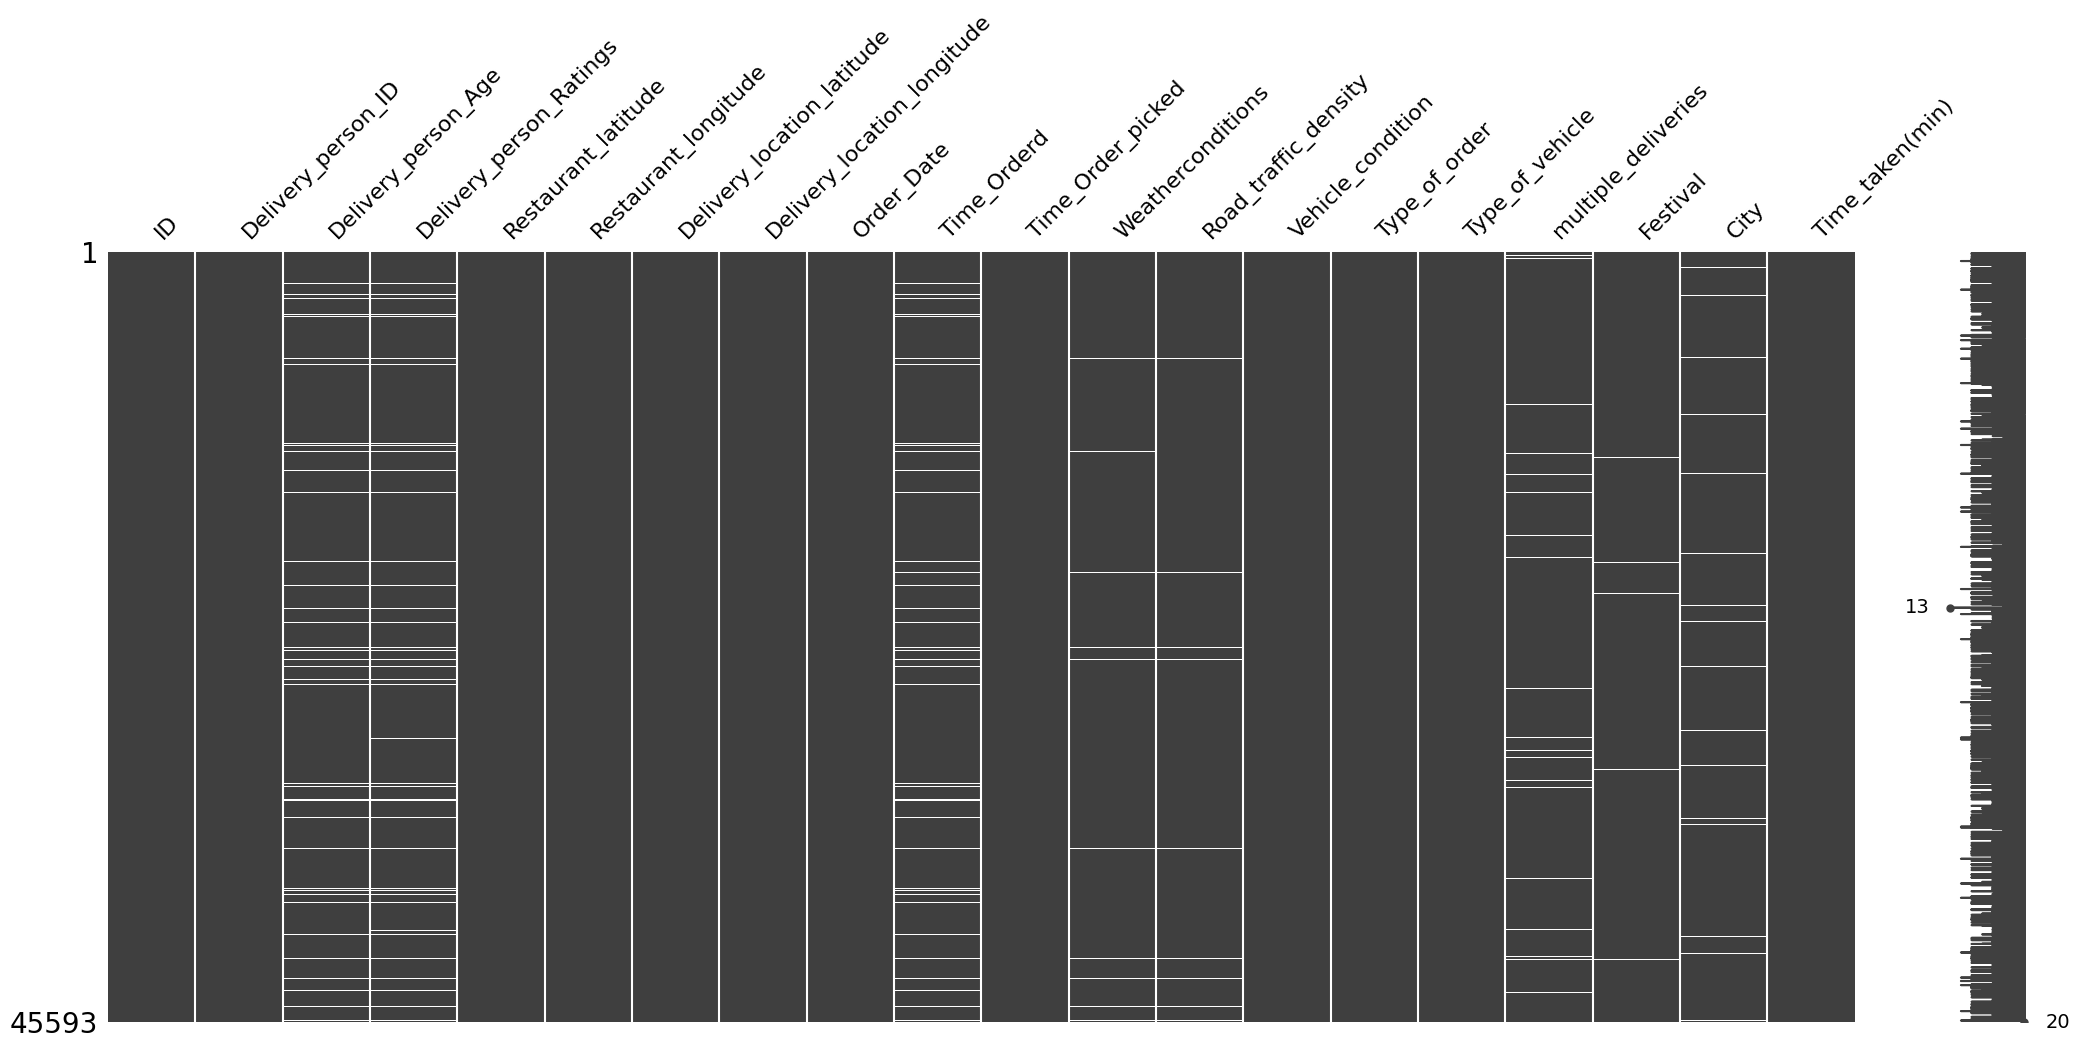

In [10]:
msno.matrix(df)
plt.show()

This chart helps us to get an overview of missing data. Now let's see number of missing values in individual columns.

In [11]:
df.isnull().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions               616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken(min)                   0
dtype: int64

In [12]:
# Calculate missing data count and percentage
missing_data_count = df.isnull().sum()
missing_data_percentage = (df.isnull().sum() / len(df)) * 100

# Create a new DataFrame to display the results
missing_data_info = pd.DataFrame({
    'Missing Count': missing_data_count,
    'Missing Percentage': missing_data_percentage
})

# Sort the DataFrame by missing percentage in descending order
missing_data_info = missing_data_info.sort_values(by='Missing Percentage', ascending=False)

# Display the missing data information
print(missing_data_info)


                             Missing Count  Missing Percentage
Delivery_person_Ratings               1908            4.184853
Delivery_person_Age                   1854            4.066414
Time_Orderd                           1731            3.796635
City                                  1200            2.631983
multiple_deliveries                    993            2.177966
Weatherconditions                      616            1.351085
Road_traffic_density                   601            1.318185
Festival                               228            0.500077
ID                                       0            0.000000
Type_of_vehicle                          0            0.000000
Type_of_order                            0            0.000000
Vehicle_condition                        0            0.000000
Time_Order_picked                        0            0.000000
Delivery_person_ID                       0            0.000000
Order_Date                               0            0

In [13]:
df.nunique()


ID                             45593
Delivery_person_ID              1320
Delivery_person_Age               22
Delivery_person_Ratings           28
Restaurant_latitude              657
Restaurant_longitude             518
Delivery_location_latitude      4373
Delivery_location_longitude     4373
Order_Date                        44
Time_Orderd                      176
Time_Order_picked                193
Weatherconditions                  6
Road_traffic_density               4
Vehicle_condition                  4
Type_of_order                      4
Type_of_vehicle                    4
multiple_deliveries                4
Festival                           2
City                               3
Time_taken(min)                   45
dtype: int64

### Dataset cleaning to do list:
* convert delivery person age,ratings,multiple deliveries to float
* extract city name from delivery person id
* convert order date, time oredered, time picked to date time
* extract other date time features from them
* extract time taken into int after splitting string


In [17]:
def dtype_update(df):
    df['Delivery_person_Age']=df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings']=df['Delivery_person_Ratings'].astype('float64')
    df['multiple_deliveries']=df['multiple_deliveries'].astype('float64')
    #df['Order_Date']=pd.to_datetime(df['Order_Date'])
    df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%Y')

    df['Time_Orderd']=pd.to_datetime(df['Time_Orderd'])
    df['Time_Order_picked']=pd.to_datetime(df['Time_Order_picked'])


In [18]:
dtype_update(df)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID                           45593 non-null  object        
 1   Delivery_person_ID           45593 non-null  object        
 2   Delivery_person_Age          43739 non-null  float64       
 3   Delivery_person_Ratings      43685 non-null  float64       
 4   Restaurant_latitude          45593 non-null  float64       
 5   Restaurant_longitude         45593 non-null  float64       
 6   Delivery_location_latitude   45593 non-null  float64       
 7   Delivery_location_longitude  45593 non-null  float64       
 8   Order_Date                   45593 non-null  datetime64[ns]
 9   Time_Orderd                  43862 non-null  datetime64[ns]
 10  Time_Order_picked            45593 non-null  datetime64[ns]
 11  Weatherconditions            44977 non-nu

### Extracting Features

In [20]:
def extract_features(df):
    #extract city code from delivery person id
    df['City_code']=df['Delivery_person_ID'].apply(lambda x: x.split('RES')[0].strip())
    #split string and convert the first term to int
    df['Time_taken(min)'] = df['Time_taken(min)'].apply(lambda x: int(x.split(' ')[1].strip()))
    #just take the second word from weather conditions which is relevant
    df['Weatherconditions']=df['Weatherconditions'].apply(lambda x: x.split(' ')[1].strip() if isinstance(x, str) else x)


In [21]:
extract_features(df)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID                           45593 non-null  object        
 1   Delivery_person_ID           45593 non-null  object        
 2   Delivery_person_Age          43739 non-null  float64       
 3   Delivery_person_Ratings      43685 non-null  float64       
 4   Restaurant_latitude          45593 non-null  float64       
 5   Restaurant_longitude         45593 non-null  float64       
 6   Delivery_location_latitude   45593 non-null  float64       
 7   Delivery_location_longitude  45593 non-null  float64       
 8   Order_Date                   45593 non-null  datetime64[ns]
 9   Time_Orderd                  43862 non-null  datetime64[ns]
 10  Time_Order_picked            45593 non-null  datetime64[ns]
 11  Weatherconditions            44977 non-nu

In [23]:
#Drop Columns which won't be use for building model
def drop_columns(df):
    df.drop(['ID','Delivery_person_ID'],axis=1,inplace=True)

drop_columns(df)

In [24]:
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,2024-03-14 11:30:00,2024-03-14 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,2024-03-14 19:45:00,2024-03-14 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,2024-03-14 08:30:00,2024-03-14 08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,2024-03-14 18:00:00,2024-03-14 18:10:00,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,2024-03-14 13:30:00,2024-03-14 13:45:00,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN


In [25]:
df.isnull().sum().sort_values(ascending=False)

Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weatherconditions               616
Road_traffic_density            601
Festival                        228
Order_Date                        0
Delivery_location_longitude       0
Time_Order_picked                 0
Delivery_location_latitude        0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
Restaurant_longitude              0
Restaurant_latitude               0
Time_taken(min)                   0
City_code                         0
dtype: int64

In [26]:
columns_with_null = df.columns[df.isnull().any()].tolist()
columns_with_null

['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Time_Orderd',
 'Weatherconditions',
 'Road_traffic_density',
 'multiple_deliveries',
 'Festival',
 'City']

In [45]:
columns_with_null=['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Weatherconditions',
 'Road_traffic_density',
 'multiple_deliveries',
 'Festival',
 'City']

### Plotting frequency distribution of columns with missing values.

<ipython-input-46-b9b4d9add325>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis')
<ipython-input-46-b9b4d9add325>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis')
<ipython-input-46-b9b4d9add325>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis')
<ipython-input-46-b9b4d9add325>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `le

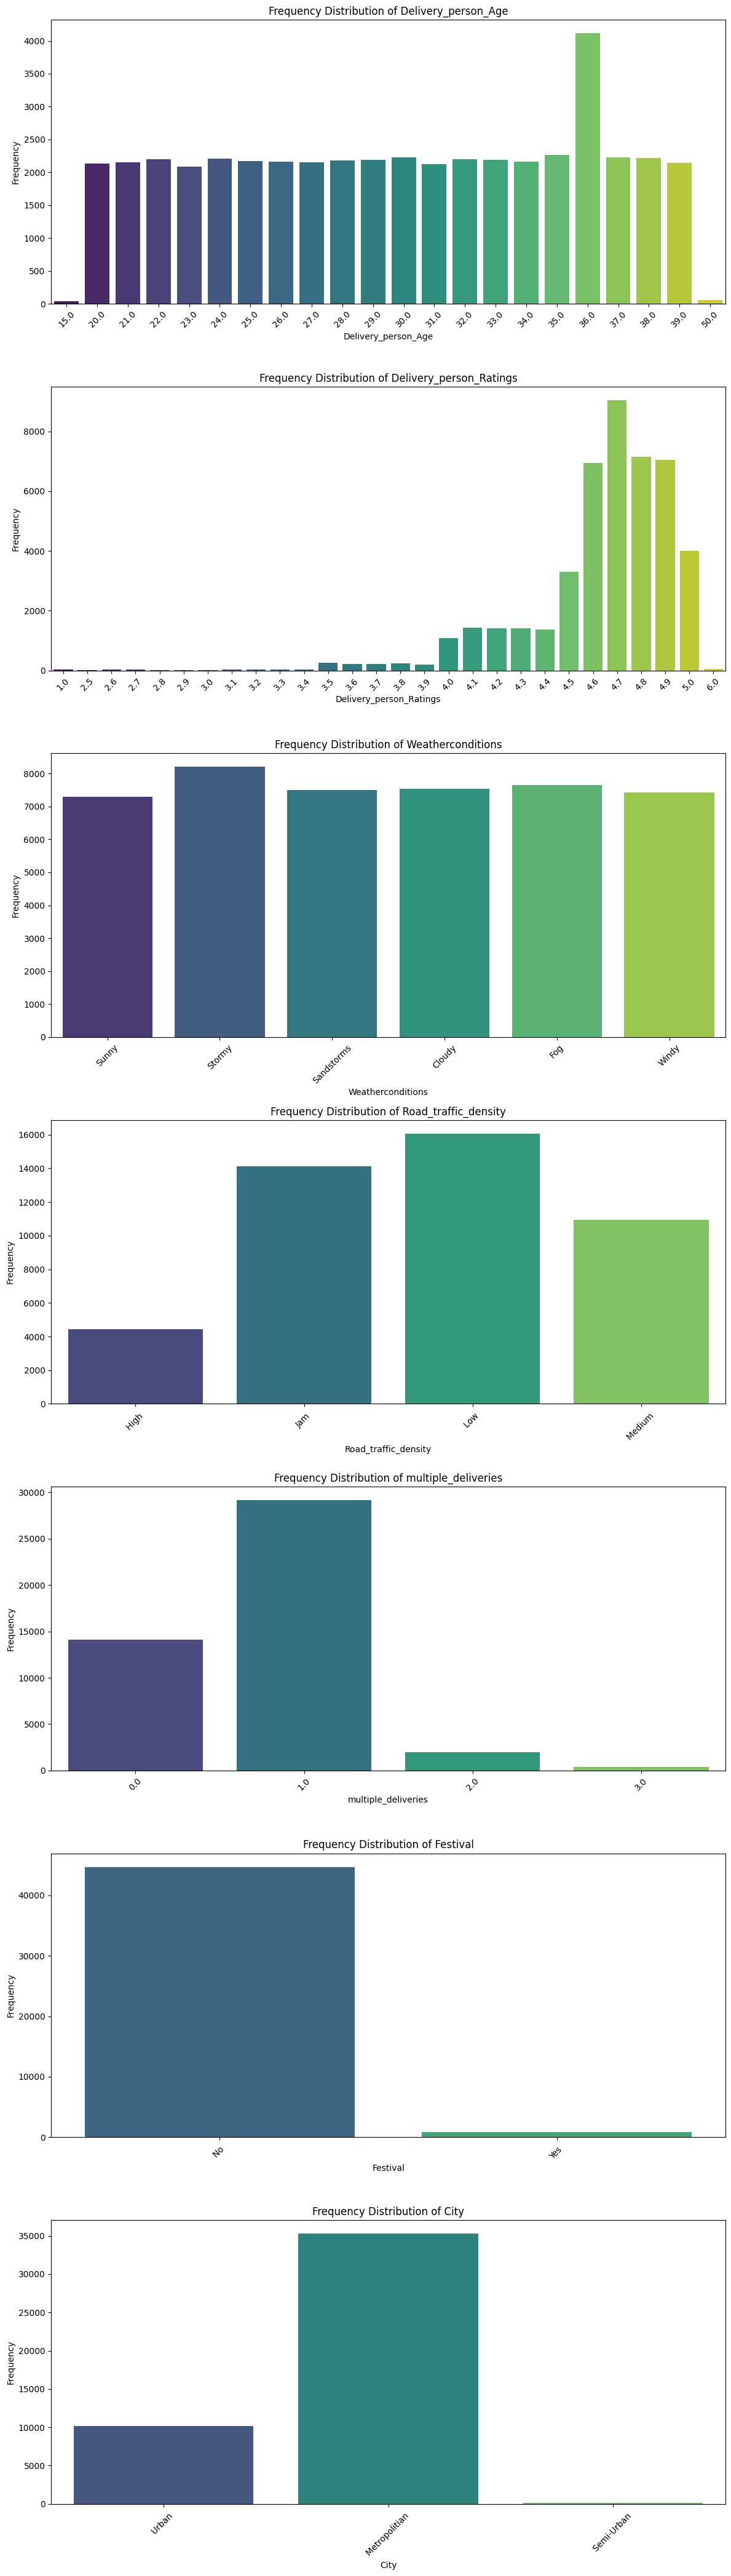

In [46]:
columns=columns_with_null
plt.figure(figsize=(12, 6*len(columns)))

for i, column in enumerate(columns, 1):
    plt.subplot(len(columns), 1, i)
    sns.countplot(data=df, x=column, palette='viridis')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Frequency Distribution of {column}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Filling the missing values
We take a look at the frequency distribution of data in columns with missing values and try to find out most suitable way to replace them. It varies column by column. We also make use of real world knowledge.

In [28]:
def fill_null(df):
    df['Delivery_person_Age'] = df['Delivery_person_Age'].fillna(np.random.choice(df['Delivery_person_Age']))
    df['Weatherconditions'] = df['Weatherconditions'].fillna(np.random.choice(df['Weatherconditions']))
    df['City'] = df['City'].fillna(df['City'].mode()[0])
    df['Festival'] = df['Festival'].fillna(df['Festival'].mode()[0])
    df['multiple_deliveries'] = df['multiple_deliveries'].fillna(df['multiple_deliveries'].mode()[0])
    df['Road_traffic_density'] = df['Road_traffic_density'].fillna(df['Road_traffic_density'].mode()[0])
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median())
    mean_time_diff = (df['Time_Order_picked'] - df['Time_Orderd']).mean()
    df['Time_Orderd'] = df.apply(lambda x: x['Time_Order_picked'] - mean_time_diff if pd.isnull(x['Time_Orderd']) else x['Time_Orderd'], axis=1)




In [29]:
fill_null(df)

In [30]:
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,2024-03-14 11:30:00,2024-03-14 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,2024-03-14 19:45:00,2024-03-14 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,2024-03-14 08:30:00,2024-03-14 08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,2024-03-14 18:00:00,2024-03-14 18:10:00,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,2024-03-14 13:30:00,2024-03-14 13:45:00,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN


### Chart to ensure all the missing values are filled.

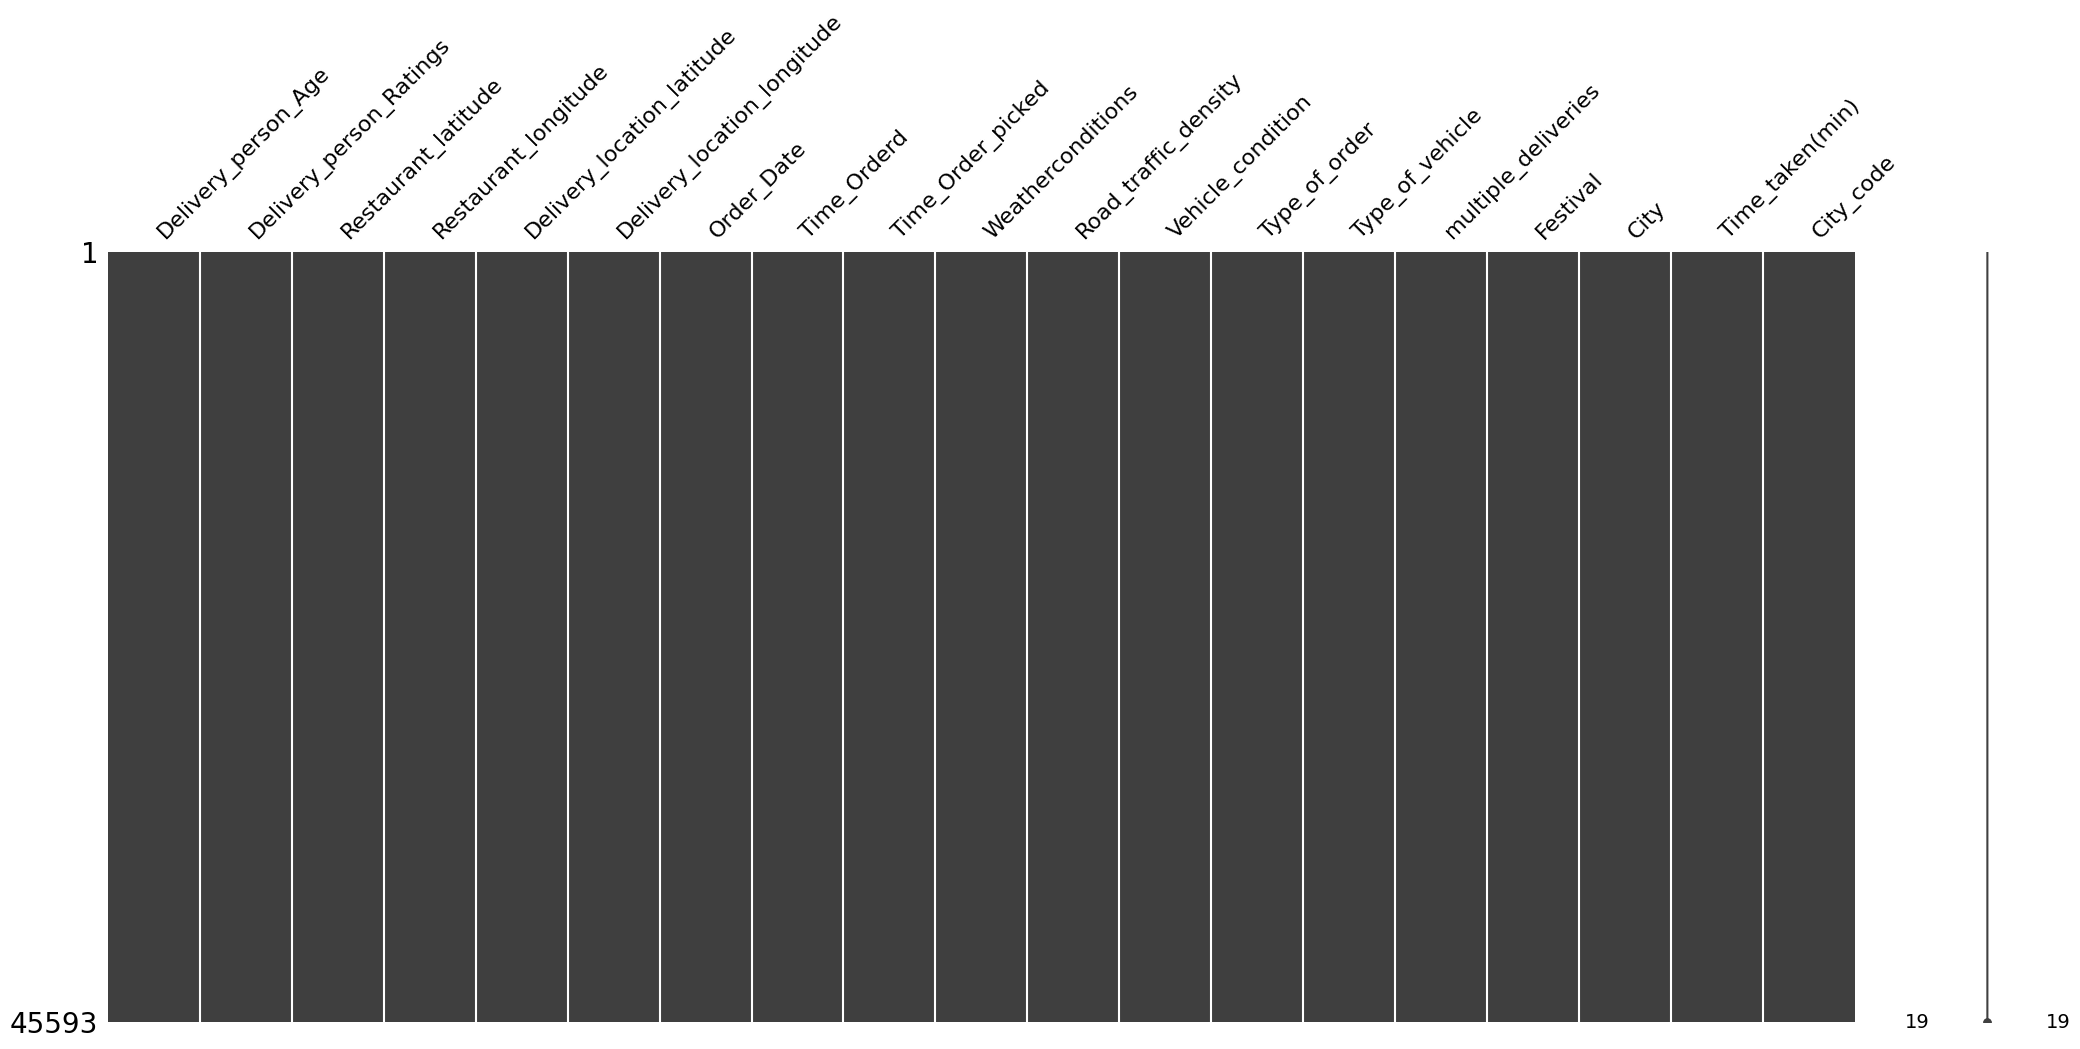

In [ ]:
msno.matrix(df)
plt.show()

### Extracting new features from date time columns


In [31]:


def extract_date_features(data):
    data["day"] = data.Order_Date.dt.day
    data["month"] = data.Order_Date.dt.month
    data["quarter"] = data.Order_Date.dt.quarter
    data["year"] = data.Order_Date.dt.year
    data['day_of_week'] = data.Order_Date.dt.day_of_week.astype(int)
    data["is_month_start"] = data.Order_Date.dt.is_month_start.astype(int)
    data["is_month_end"] = data.Order_Date.dt.is_month_end.astype(int)
    data["is_quarter_start"] = data.Order_Date.dt.is_quarter_start.astype(int)
    data["is_quarter_end"] = data.Order_Date.dt.is_quarter_end.astype(int)
    data["is_year_start"] = data.Order_Date.dt.is_year_start.astype(int)
    data["is_year_end"] = data.Order_Date.dt.is_year_end.astype(int)
    data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]),1,0)


In [32]:
extract_date_features(df)

In [33]:
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,...,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,2024-03-14 11:30:00,2024-03-14 11:45:00,Sunny,...,1,2022,5,0,0,0,0,0,0,1
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,2024-03-14 19:45:00,2024-03-14 19:50:00,Stormy,...,1,2022,4,0,0,0,0,0,0,0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,2024-03-14 08:30:00,2024-03-14 08:45:00,Sandstorms,...,1,2022,5,0,0,0,0,0,0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,2024-03-14 18:00:00,2024-03-14 18:10:00,Sunny,...,2,2022,1,0,0,0,0,0,0,0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,2024-03-14 13:30:00,2024-03-14 13:45:00,Cloudy,...,1,2022,5,0,0,0,0,0,0,1


In [34]:
def time_difference(df):
    df['Prep_time']=(df['Time_Order_picked'] - df['Time_Orderd']).dt.seconds / 60


In [35]:
time_difference(df)


In [36]:
df.drop(['Time_Orderd', 'Time_Order_picked','Order_Date'], axis=1, inplace=True)


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Delivery_person_Age          45593 non-null  float64
 1   Delivery_person_Ratings      45593 non-null  float64
 2   Restaurant_latitude          45593 non-null  float64
 3   Restaurant_longitude         45593 non-null  float64
 4   Delivery_location_latitude   45593 non-null  float64
 5   Delivery_location_longitude  45593 non-null  float64
 6   Weatherconditions            45593 non-null  object 
 7   Road_traffic_density         45593 non-null  object 
 8   Vehicle_condition            45593 non-null  int64  
 9   Type_of_order                45593 non-null  object 
 10  Type_of_vehicle              45593 non-null  object 
 11  multiple_deliveries          45593 non-null  float64
 12  Festival                     45593 non-null  object 
 13  City            

### Calculate distance between restaurant and customer


In [38]:

from geopy.distance import geodesic


def calculate_distance(df):
    restaurant_coordinates = df[['Restaurant_latitude', 'Restaurant_longitude']]
    delivery_location_coordinates = df[['Delivery_location_latitude', 'Delivery_location_longitude']]
    df['distance'] = [geodesic(restaurant, delivery).meters for restaurant, delivery in zip(restaurant_coordinates.values, delivery_location_coordinates.values)]



In [39]:
calculate_distance(df)


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Delivery_person_Age          45593 non-null  float64
 1   Delivery_person_Ratings      45593 non-null  float64
 2   Restaurant_latitude          45593 non-null  float64
 3   Restaurant_longitude         45593 non-null  float64
 4   Delivery_location_latitude   45593 non-null  float64
 5   Delivery_location_longitude  45593 non-null  float64
 6   Weatherconditions            45593 non-null  object 
 7   Road_traffic_density         45593 non-null  object 
 8   Vehicle_condition            45593 non-null  int64  
 9   Type_of_order                45593 non-null  object 
 10  Type_of_vehicle              45593 non-null  object 
 11  multiple_deliveries          45593 non-null  float64
 12  Festival                     45593 non-null  object 
 13  City            

### Splitting data and preprocessing



*   We seperate dependent/target variable from independent variables
*   Split data into training and testing sets.

*   Identify categorical and numerical columns
*   Encode categorical columns, scale numerical columns
*   Add these steps in a  pipline object.
*   Fit pipeline on training data, then transform training an testing data









In [41]:
X=df.drop('Time_taken(min)',axis=1)
y=df['Time_taken(min)']

X.shape,y.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(include=['int', 'float']).columns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Create a pipeline for preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

pipeline.fit(X_train)

# Transform the training and test data
X_train_processed = pipeline.transform(X_train)
X_test_processed = pipeline.transform(X_test)


(36474, 29)
(36474,)
(9119, 29)
(9119,)


## Saving processed data
This saves us time when we want to check some new models. Instead of going through entire filling, encoding, scaling etc we can directly train our model on processed data.

In [ ]:
np.savetxt('X_train_processed.csv', X_train_processed, delimiter=',')
np.savetxt('X_test_processed.csv', X_test_processed, delimiter=',')

In [ ]:
np.savetxt('y_train.csv', y_train, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')

## Building models


First we start with a simple Linear regression model and see how it performs.

### Linear Regression

In [ ]:
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression

lr=LinearRegression()

lr.fit(X_train_processed,y_train)

y_pred_lr = lr.predict(X_test_processed)

r2_lr = r2_score(y_test, y_pred_lr)

r2_lr

0.556047567618331

R2 score of the linear regression model is 0.55 which is not very good. Let's use a regularization and see if the performance improves.

First we try ridge or L2 regularization, then try lasso or L1 regularization.

### Ridge Regression

In [50]:
ridge = Ridge(alpha=1.0, random_state=0)
ridge.fit(X_train_processed, y_train)
y_pred_ridge = ridge.predict(X_test_processed)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge Regression R-squared:", r2_ridge)

Ridge Regression R-squared: 0.5554233155311686


In [ ]:
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0]
}
grid_search_ridge = GridSearchCV(Ridge(random_state=0), param_grid_ridge, cv=5, scoring='r2')
grid_search_ridge.fit(X_train_processed, y_train)
ridge_best = grid_search_ridge.best_estimator_
y_pred_ridge_best = ridge_best.predict(X_test_processed)
r2_ridge_best = r2_score(y_test, y_pred_ridge_best)
print("Improved Ridge Regression R-squared:", r2_ridge_best)


Improved Ridge Regression R-squared: 0.5561035204198109


### Lasso Regression

In [ ]:
param_grid_lasso = {
    'alpha': [0.1, 1.0, 10.0]
}
grid_search_lasso = GridSearchCV(Lasso(random_state=0), param_grid_lasso, cv=5, scoring='r2')
grid_search_lasso.fit(X_train_processed, y_train)
lasso_best = grid_search_lasso.best_estimator_
y_pred_lasso_best = lasso_best.predict(X_test_processed)
r2_lasso_best = r2_score(y_test, y_pred_lasso_best)
print("Improved Lasso Regression R-squared:", r2_lasso_best)

Improved Lasso Regression R-squared: 0.5428212025115909


Performance has imporved a bit but not significantly. Clearly we can see linear model is not able to completely capture the relationship between independent variables and dependent variable.

Now, we try non linear model such as decision tree. Often nonlinear models can capture complex relationships between variables that linear models cannot.

### Decision Tree

In [ ]:
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train_processed, y_train)
y_pred_dt = dt.predict(X_test_processed)
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree R-squared:", r2_dt)


Decision Tree R-squared: 0.6461717311084731


R2 score for decision tree is 0.65 which is significantly better than the linear regression model.

We can tune various parameters of decision tree such as maximum depth, minimum sample leafs etc to find the best model.

We will use grid search cv with 5 fold cross validation.
Grid search tries all the different combinations from the parameter grids and gives us the best performing model based on our scoring method which is R2 score in this case.

5 fold cross validation is used as it provides better estimate of model performance than one split. Entire dataset is split in 5 folds, four used for training, one for validation. It helps reduce the variance of the estimated performance metric compared to a single train-test split, as the model is evaluated on multiple different subsets of the data.

### Hyperparameter tuning for decision tree

In [ ]:
param_grid_dt = {
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10]
}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid_dt, cv=5, scoring='r2')
grid_search.fit(X_train_processed, y_train)
dt_best = grid_search.best_estimator_
y_pred_dt_best = dt_best.predict(X_test_processed)
r2_dt_best = r2_score(y_test, y_pred_dt_best)
print("Improved Decision Tree R-squared:", r2_dt_best)

Improved Decision Tree R-squared: 0.7966948713696258


Wow R2 score of 0.79, that's a massive improvement in performance.
We can use ensamble technique to further improve performance. Here instead of one decision tree, we train multiple trees and final model is made by combining the individual trees.  

### Random Forest

In [ ]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train_processed, y_train)
y_pred_rf = rf.predict(X_test_processed)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest R-squared:", r2_rf)

Random Forest R-squared: 0.8094159475692384


In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=0), param_grid_rf, cv=5, scoring='r2')
grid_search_rf.fit(X_train_processed, y_train)
rf_best = grid_search_rf.best_estimator_
y_pred_rf_best = rf_best.predict(X_test_processed)
r2_rf_best = r2_score(y_test, y_pred_rf_best)
print("Improved Random Forest R-squared:", r2_rf_best)


Improved Random Forest R-squared: 0.815270600605313


### XGBoost

We now use boosting to see if we can improve the model performance.
XGBoost belongs to the family of ensemble learning methods based on decision trees. It is an implementation of gradient boosting machines, which build a sequence of trees, where each tree corrects the errors of the previous ones.

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search_xgb = GridSearchCV(XGBRegressor(random_state=0), param_grid_xgb, cv=5, scoring='r2')
grid_search_xgb.fit(X_train_processed, y_train)
xgb_best = grid_search_xgb.best_estimator_
y_pred_xgb_best = xgb_best.predict(X_test_processed)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)
print("Improved XGBoost R-squared:", r2_xgb_best)


Improved XGBoost R-squared: 0.8175235702207211


### Saving trained models

We can reuse the trained model to make predictions on new data without having to retrain the model. This can save time and computational resources, especially for complex models that take a long time to train.

In [ ]:
from joblib import dump


In [ ]:

dump(xgb_best, 'best_xgb_model.joblib')

['best_xgb_model.joblib']

In [ ]:
dump(rf_best, 'best_rf_model.joblib')
dump(dt_best, 'best_dt_model.joblib')


['best_dt_model.joblib']